In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Interpolation with PyMC3

## A 1D example

To start, we'll do a simple 1D example where we have a model evaluated at control points and we interpolate between them to estimate the model value.

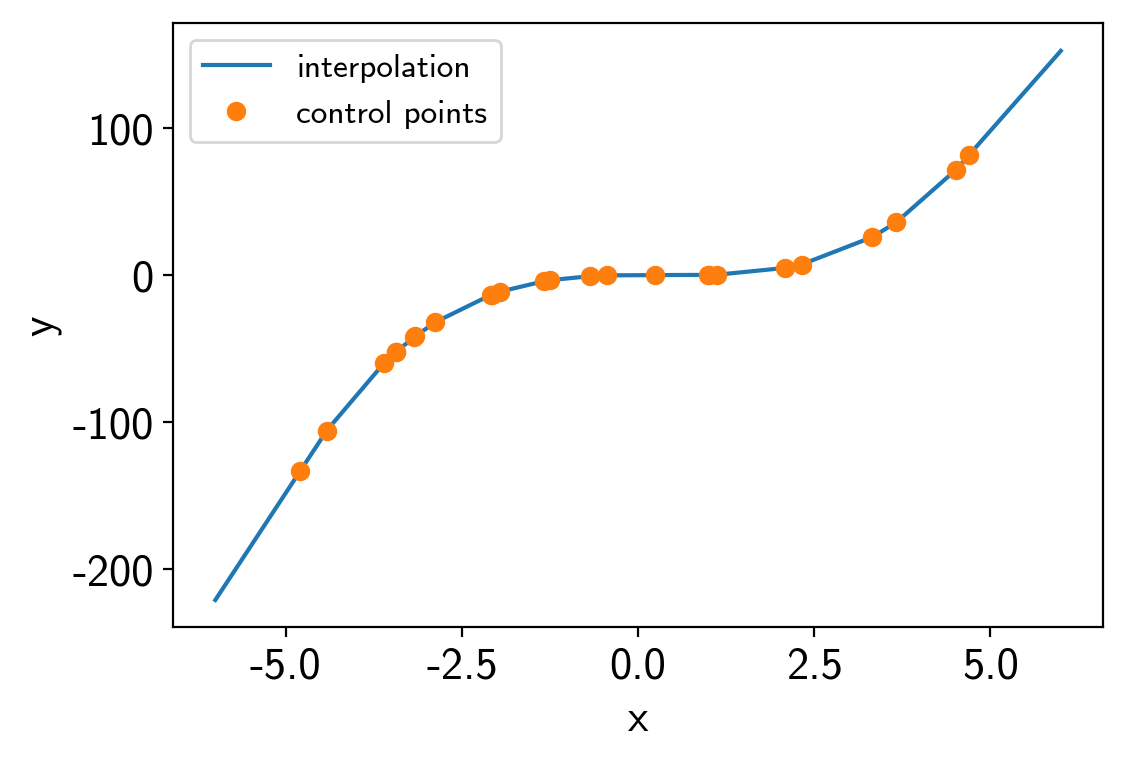

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

np.random.seed(42)
x = np.sort(np.random.uniform(-5, 5, 25))
points = [x]
values = x**3-x**2

interpolator = xo.interp.RegularGridInterpolator(points, values[:, None])

t = np.linspace(-6, 6, 5000)
plt.plot(t, interpolator.evaluate(t[:, None]).eval(), label="interpolation")
plt.plot(x, values, "o", label="control points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=12);

Here's how we build the PyMC3 model:

In [4]:
import pymc3 as pm

truth = 45.0
data_sd = 8.0
data_mu = truth + data_sd * np.random.randn()

with pm.Model() as model:
    
    # The value passed into the interpolator must have the shape
    # (ntest, ndim), but in our case that is (1, 1)
    xval = pm.Uniform("x", lower=-8, upper=8, shape=(1, 1))
    
    # Evaluate the interpolated model and extract the scalar value
    # we want
    mod = pm.Deterministic("y", interpolator.evaluate(xval)[0, 0])
    
    # The usual likelihood
    pm.Normal("obs", mu=mod, sd=data_sd, observed=data_mu)
    
    # Sampling!
    trace = pm.sample(draws=1000, tune=2000, step_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2937.41draws/s]


And here are the results:

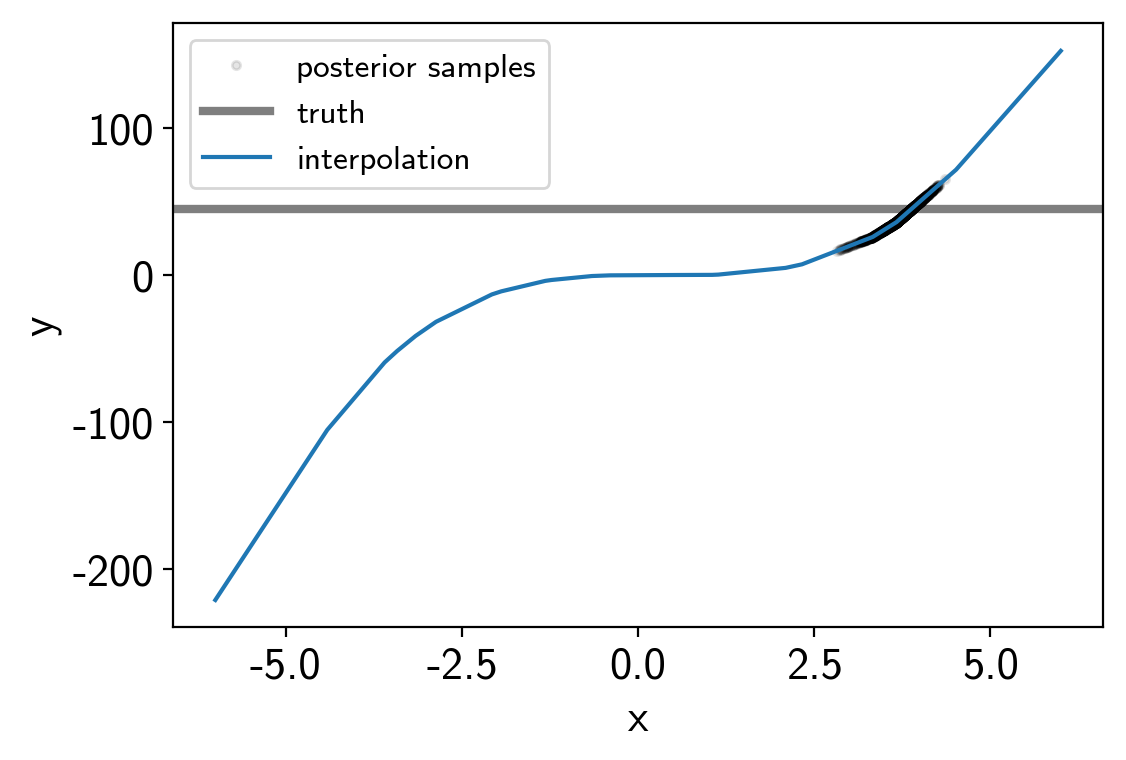

In [6]:
t = np.linspace(-6, 6, 5000)
plt.plot(trace["x"][:, 0, 0], trace["y"], ".k", alpha=0.1, label="posterior samples")
plt.axhline(truth, color="k", lw=3, alpha=0.5, label="truth")
plt.plot(t, interpolator.evaluate(t[:, None]).eval(), label="interpolation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=12);

## A 2D example

In this case, we'll interpolate a 2D function. This one is a hard one because the posterior is a ring, but it demonstrates the principle.

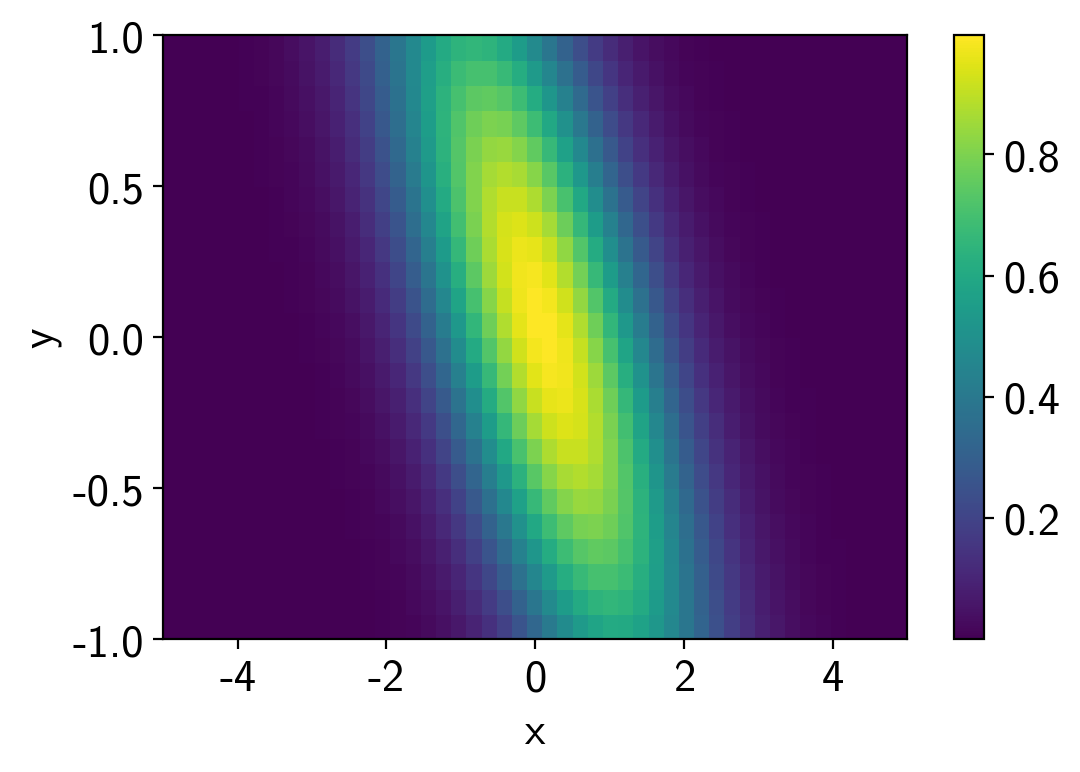

In [39]:
points = [
    np.linspace(-5, 5, 50),
    np.linspace(-1, 1, 25),
]
values = np.exp(-0.5*(points[0]**2)[:, None] - 0.5*(points[1]**2 / 0.5)[None, :] - points[0][:, None]*points[1][None, :])

interpolator = xo.interp.RegularGridInterpolator(points, values[:, :, None], nout=1)

plt.pcolor(points[0], points[1], values.T)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y");

Set things up and sample.

In [37]:
import theano.tensor as tt

data_mu = 0.6
data_sd = 0.1

with pm.Model() as model:
    
    xval = pm.Uniform("x", lower=-5, upper=5, shape=(1,))
    yval = pm.Uniform("y", lower=-1, upper=1, shape=(1,))
    xtest = tt.stack([xval, yval], axis=-1)
    
    mod = interpolator.evaluate(xtest)
    
    # The usual likelihood
    pm.Normal("obs", mu=mod, sd=data_sd, observed=data_mu)
    
    # Sampling!
    trace = pm.sample(draws=4000, tune=4000, step_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y, x]
Sampling 2 chains: 100%|██████████| 16000/16000 [00:12<00:00, 1241.36draws/s]
The number of effective samples is smaller than 10% for some parameters.


And here are the results:

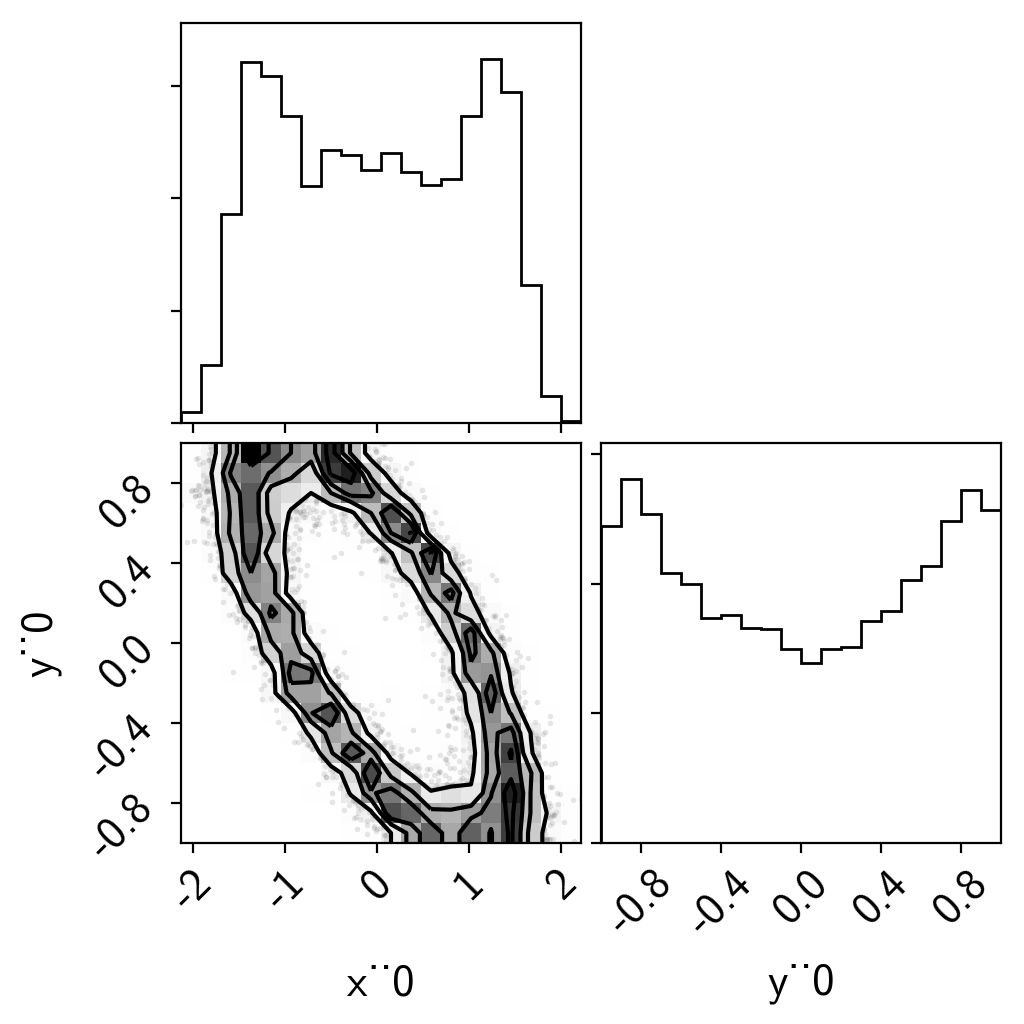

In [38]:
import corner
samples = pm.trace_to_dataframe(trace)
corner.corner(samples);